# The Farmer's Problem and Variants

The [Farmer's Problem](https://www.math.uh.edu/~rohop/Spring_15/Chapter1.pdf) is a teaching example presented in the well-known textbook by John Birge and Francois Louveaux.

* Birge, John R., and Francois Louveaux. Introduction to stochastic programming. Springer Science & Business Media, 2011.

In [298]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_cbc()

pyomo was previously installed
cbc was previously installed


True

In [299]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyomo.environ as pyo

## Problem Statement

In the [farmer's problem](https://www.math.uh.edu/~rohop/Spring_15/Chapter1.pdf), a European farmer must allocate 500 acres of land among three different crops (wheat, corn, and sugar beets) aiming to maximize profit. The following information is given:

* Planting one acre of wheat, corn and beet costs 150, 230 and 260 euro, respectively.

* The mean yields are 2.5, 3.0, and 20.0 tons per acre for wheat, corn, and sugar beets, respectively. The yields can vary up to 20% from nominal conditions depending on weather.

* At least 200 tons of wheat and 240 tons of corn are needed for cattle feed. Cattle feed can be raised on the farm or purchased from a wholesaler. 

* The mean selling prices have been \\$170 and \\$150 per ton of wheat and corn, respectively, over the last decade. The purchase prices are 40% more due to wholesaler's margins and transportation costs.

* Sugar beets are a profitable crop expected to sell at 36 euro per ton, but there is a quota on sugar beet production. Any amount in excess of the quota can be sold at only 10 euro per ton. The farmer's quota for next year is 6,000 tons.

Create three solutions for the farmer to consider.

1. How should the farmer allocate land to maximize profit for the mean weather conditions?

2. The second solution should explicitly consider the impact of weather. How should the farmer allocate land to maximize expected profit if the yields could go up or down by 20% due to weather conditions? What is the profit under each scenario?

3. During your interview you learned the farmer needs a minimal profit each year to stay in business. How would you allocate land use to maximize the worst case profit?  

4. Determine the tradeoff between risk and return by computing the mean expected profit when the minimum required profit is the worst case found in part 3, and \\$58,000, \\$56,000, \\$54,000, \\$52,000, \\$50,000, and \\$48,000. Compare these solutions to part 2 by plotting the expected loss in profit. 

5. What would be your advice to the farmer regarding land allocation?

## Data Summary

| Scenario | Yield for wheat <br> (tons/acre)| Yield for corn <br> (tons/acre) | Yield for beets <br> (tons/acre) |
| :-- | :-: | :-: | :-: |
| Good weather | 3 | 3.6 | 24 |
| Average weather | 2.5 | 3 | 20 |
| Bad weather | 2 | 2.4 | 16 |

We first consider the case in which all the prices are fixed and not weather-dependent. The following table summarizes the data.

| Commodity | Sell <br> Price <br> (euro/ton) | Market <br> Demand <br> (tons) | Excess Price | Buy <br> Price <br> (euro/ton) | Cattle Feed <br> Required <br> (tons) | Planting <br> Cost <br> (euro/acre) |
| :-- | :--: | :--: | :--: | :--: | :--: | :--: |
| Wheat | 170 | - | _ | 238 | 200 | 150 |
| Corn | 150 | - | - | 210 | 240 | 230 |
| Beets | 36 | 6000 | 10 | 0 | - | 260 |


## Data Modeling

In [339]:
yields = pd.DataFrame({
    "good":    {"wheat": 3.0, "corn": 3.6, "beets": 24},
    "average": {"wheat": 2.5, "corn": 3.0, "beets": 20},
    "poor":    {"wheat": 2.0, "corn": 2.4, "beets": 16},
}).T
display(yields)

,wheat,corn,beets
good,3.0,3.6,24.0
average,2.5,3.0,20.0
poor,2.0,2.4,16.0


In [300]:
crops = pd.DataFrame({
    "wheat": {"planting cost": 150, "sell": 170, "buy": 238, "required": 200},
    "corn":  {"planting cost": 230, "sell": 150, "buy": 210, "required": 240},
    "beets": {"planting cost": 260, "sell": 36, "quota":  6000, "excess": 10},
}).T

# fill NaN

bigM = 20000
crops["buy"].fillna(bigM, inplace=True)
crops["quota"].fillna(bigM, inplace=True)
crops["required"].fillna(0, inplace=True)
crops["excess"].fillna(0, inplace=True)

display(crops)

,planting cost,sell,buy,required,quota,excess
wheat,150.0,170.0,238.0,200.0,20000.0,0.0
corn,230.0,150.0,210.0,240.0,20000.0,0.0
beets,260.0,36.0,20000.0,0.0,6000.0,10.0


## Model Building

In [343]:
import pyomo.environ as pyo
import pyomo.gdp as gdp

def farmer(crops, yields, total_land=500):
    
    m = pyo.ConcreteModel("Farmer's Problem")
    
    m.CROPS = pyo.Set(initialize=crops.index)
    m.SCENARIOS = pyo.Set(initialize=yields.index)
    
    # first stage variables
    m.acres = pyo.Var(m.CROPS, bounds=(0, total_land))
    
    # second stage variables (all units in tons)
    bounds = (0, yields.max().max() * total_land)
    m.grow = pyo.Var(m.SCENARIOS, m.CROPS, bounds=bounds)
    m.buy = pyo.Var(m.SCENARIOS, m.CROPS, bounds=bounds)
    m.sell = pyo.Var(m.SCENARIOS, m.CROPS, bounds=bounds)
    m.excess = pyo.Var(m.SCENARIOS, m.CROPS, bounds=bounds)
    
    # first stage model
    @m.Constraint()
    def limit_on_planted_land(m):
        return pyo.summation(m.acres) <= total_land
    
    # second stage model   
    @m.Constraint(m.SCENARIOS, m.CROPS)
    def crop_yield(m, s, c):
        return m.grow[s, c] == yields.loc[s, c] * m.acres[c]
    
    @m.Constraint(m.SCENARIOS, m.CROPS)
    def balance(m, s, c):
        return m.grow[s, c] + m.buy[s, c] == m.sell[s, c] + crops.loc[c, "required"] + m.excess[s, c]
    
    @m.Disjunction(m.SCENARIOS, m.CROPS, xor=True)
    def quota(m, s, c):
        under_quota = [m.grow[s, c] <= crops.loc[c, "quota"],
                       m.excess[s, c] ==  0]
        over_quota  = [m.grow[s, c] >= crops.loc[c, "quota"],
                       m.sell[s, c] <= crops.loc[c, "quota"]]
        return [under_quota, over_quota]
    
    # expressions for objective functions
    @m.Expression(m.SCENARIOS, m.CROPS)
    def expense(m, s, c):
        return crops.loc[c, "planting cost"] * m.acres[c] + crops.loc[c, "buy"] * m.buy[s, c] 
    
    @m.Expression(m.SCENARIOS, m.CROPS)
    def revenue(m, s, c):
        return crops.loc[c, "sell"] * m.sell[s, c] + crops.loc[c, "excess"] * m.excess[s, c]
    
    @m.Expression(m.SCENARIOS)
    def scenario_profit(m, s):
        return sum(m.revenue[s, c] - m.expense[s, c] for c in m.CROPS)
    
    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    return m

In [344]:
def farm_report(m):
    print(f"Objective = {m.objective():0.2f}")
    for s in m.SCENARIOS:
        print(f"\nScenario: {s}")
        print(f"Scenario profit = {m.scenario_profit[s]()}")
        df = pd.DataFrame()
        df["plant [acres]"] = pd.Series({c: m.acres[c]() for c in m.CROPS})
        df["grow [tons]"] = pd.Series({c: m.grow[s, c]() for c in m.CROPS})
        df["buy [tons]"] = pd.Series({c: m.buy[s, c]() for c in m.CROPS})
        df["feed [tons]"] = pd.Series({c: commodities.loc[c, "required"] for c in m.CROPS})
        df["quota [tons]"] = pd.Series({c: crops.loc[c, "quota"] for c in m.CROPS})
        df["sell [tons]"] = pd.Series({c: m.sell[s, c]() for c in m.CROPS})
        df["excess [tons]"] = pd.Series({c: m.excess[s, c]() for c in m.CROPS})
        df["revenue [euro]"] = pd.Series({c: m.revenue[s, c]() for c in m.CROPS})
        df["expense [euro]"] = pd.Series({c: m.expense[s, c]() for c in m.CROPS})
        df["profit [euro]"] = pd.Series({c: m.revenue[s, c]() - m.expense[s, c]() for c in m.CROPS})
        display(df.round(2))

## 1. Mean Solution

In [345]:
m = farmer(crops, pd.DataFrame(yields.mean(), columns=["mean"]).T)

@m.Objective(sense=pyo.maximize)
def objective(m):
    return pyo.summation(m.scenario_profit)

pyo.SolverFactory('cbc').solve(m)
farm_report(m)

Objective = 118600.00

Scenario: mean
Scenario profit = 118600.0


,plant [acres],grow [tons],buy [tons],feed [tons],quota [tons],sell [tons],excess [tons],revenue [euro],expense [euro],profit [euro]
wheat,120.0,300.0,0.0,200.0,20000.0,100.0,0.0,17000.0,18000.0,-1000.0
corn,80.0,240.0,0.0,240.0,20000.0,0.0,0.0,0.0,18400.0,-18400.0
beets,300.0,6000.0,0.0,0.0,6000.0,6000.0,0.0,216000.0,78000.0,138000.0


## 2. Stochastic Solution


The problem statement asks for a number of different analyses. In a consulting situation, it is possible the client would ask more "what if" questions after hearing the initial results. For these reasons, we build a function that returns a Pyomo model the variables and expressions needed to address all parts of the problem. 

In [346]:
# maximize mean profit
m = farmer(crops, yields)

@m.Objective(sense=pyo.maximize)
def objective(m):
    return pyo.summation(m.scenario_profit) / len(m.SCENARIOS)

pyo.SolverFactory('cbc').solve(m)
farm_report(m)

Objective = 108390.00

Scenario: good
Scenario profit = 167000.0


,plant [acres],grow [tons],buy [tons],feed [tons],quota [tons],sell [tons],excess [tons],revenue [euro],expense [euro],profit [euro]
wheat,170.0,510.0,0.0,200.0,20000.0,310.0,0.0,52700.0,25500.0,27200.0
corn,80.0,288.0,0.0,240.0,20000.0,48.0,0.0,7200.0,18400.0,-11200.0
beets,250.0,6000.0,0.0,0.0,6000.0,6000.0,0.0,216000.0,65000.0,151000.0



Scenario: average
Scenario profit = 109350.0


,plant [acres],grow [tons],buy [tons],feed [tons],quota [tons],sell [tons],excess [tons],revenue [euro],expense [euro],profit [euro]
wheat,170.0,425.0,0.0,200.0,20000.0,225.0,0.0,38250.0,25500.0,12750.0
corn,80.0,240.0,0.0,240.0,20000.0,0.0,0.0,0.0,18400.0,-18400.0
beets,250.0,5000.0,0.0,0.0,6000.0,5000.0,0.0,180000.0,65000.0,115000.0



Scenario: poor
Scenario profit = 48820.0


,plant [acres],grow [tons],buy [tons],feed [tons],quota [tons],sell [tons],excess [tons],revenue [euro],expense [euro],profit [euro]
wheat,170.0,340.0,0.0,200.0,20000.0,140.0,0.0,23800.0,25500.0,-1700.0
corn,80.0,192.0,48.0,240.0,20000.0,0.0,0.0,0.0,28480.0,-28480.0
beets,250.0,4000.0,0.0,0.0,6000.0,4000.0,0.0,144000.0,65000.0,79000.0


## 3. Worst Case Solution

In [351]:
# find worst case profit
m = farmer(crops, yields)

m.worst_case_profit = pyo.Var()

@m.Constraint(m.SCENARIOS)
def lower_bound_profit(m, s):
    return m.worst_case_profit <= m.scenario_profit[s]

@m.Objective(sense=pyo.maximize)
def objective(m):
    return m.worst_case_profit

pyo.SolverFactory('cbc').solve(m)
farm_report(m)

Objective = 59950.00

Scenario: good
Scenario profit = 113250.0


,plant [acres],grow [tons],buy [tons],feed [tons],quota [tons],sell [tons],excess [tons],revenue [euro],expense [euro],profit [euro]
wheat,100.0,300.0,0.0,200.0,20000.0,100.0,0.0,17000.0,15000.0,2000.0
corn,25.0,90.0,150.0,240.0,20000.0,0.0,0.0,0.0,37250.0,-37250.0
beets,375.0,9000.0,0.0,0.0,6000.0,6000.0,3000.0,246000.0,97500.0,148500.0



Scenario: average
Scenario profit = 59950.0


,plant [acres],grow [tons],buy [tons],feed [tons],quota [tons],sell [tons],excess [tons],revenue [euro],expense [euro],profit [euro]
wheat,100.0,250.0,0.0,200.0,20000.0,50.0,0.0,8500.0,15000.0,-6500.0
corn,25.0,75.0,165.0,240.0,20000.0,0.0,0.0,0.0,40400.0,-40400.0
beets,375.0,7500.0,0.0,0.0,6000.0,4975.0,2525.0,204350.0,97500.0,106850.0



Scenario: poor
Scenario profit = 59950.0


,plant [acres],grow [tons],buy [tons],feed [tons],quota [tons],sell [tons],excess [tons],revenue [euro],expense [euro],profit [euro]
wheat,100.0,200.0,0.0,200.0,20000.0,0.0,0.0,0.0,15000.0,-15000.0
corn,25.0,60.0,180.0,240.0,20000.0,0.0,0.0,0.0,43550.0,-43550.0
beets,375.0,6000.0,0.0,0.0,6000.0,6000.0,0.0,216000.0,97500.0,118500.0


In [352]:
worst_case_profit = m.worst_case_profit()

# maximize expected profit subject to worst case as lower bound

m = farmer(crops, yields)

@m.Constraint(m.SCENARIOS)
def lower_bound_profit(m, s):
    return worst_case_profit <= m.scenario_profit[s]

@m.Objective(sense=pyo.maximize)
def objective(m):
    return pyo.summation(m.scenario_profit) / len(m.SCENARIOS)

pyo.SolverFactory('cbc').solve(m)
farm_report(m)

Objective = 86600.00

Scenario: good
Scenario profit = 113250.0


,plant [acres],grow [tons],buy [tons],feed [tons],quota [tons],sell [tons],excess [tons],revenue [euro],expense [euro],profit [euro]
wheat,100.0,300.0,0.0,200.0,20000.0,100.0,0.0,17000.0,15000.0,2000.0
corn,25.0,90.0,150.0,240.0,20000.0,0.0,0.0,0.0,37250.0,-37250.0
beets,375.0,9000.0,0.0,0.0,6000.0,6000.0,3000.0,246000.0,97500.0,148500.0



Scenario: average
Scenario profit = 86600.0


,plant [acres],grow [tons],buy [tons],feed [tons],quota [tons],sell [tons],excess [tons],revenue [euro],expense [euro],profit [euro]
wheat,100.0,250.0,0.0,200.0,20000.0,50.0,0.0,8500.0,15000.0,-6500.0
corn,25.0,75.0,165.0,240.0,20000.0,0.0,0.0,0.0,40400.0,-40400.0
beets,375.0,7500.0,0.0,0.0,6000.0,6000.0,1500.0,231000.0,97500.0,133500.0



Scenario: poor
Scenario profit = 59950.0


,plant [acres],grow [tons],buy [tons],feed [tons],quota [tons],sell [tons],excess [tons],revenue [euro],expense [euro],profit [euro]
wheat,100.0,200.0,0.0,200.0,20000.0,0.0,0.0,0.0,15000.0,-15000.0
corn,25.0,60.0,180.0,240.0,20000.0,0.0,0.0,0.0,43550.0,-43550.0
beets,375.0,6000.0,0.0,0.0,6000.0,6000.0,0.0,216000.0,97500.0,118500.0


## 4. Risk versus Return

<AxesSubplot:xlabel='worst case', ylabel='mean return'>

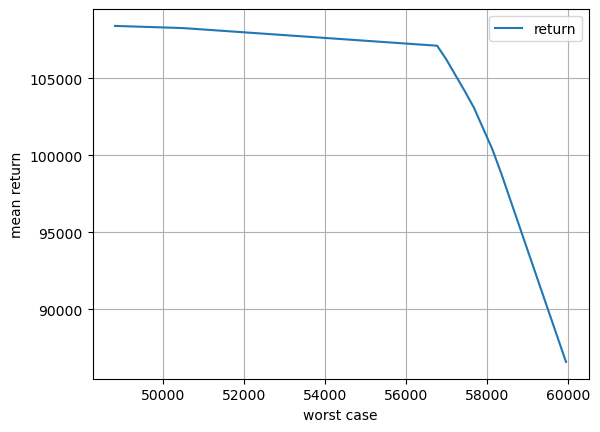

In [368]:
df = pd.DataFrame()

for wc in np.linspace(48820, 59950, 50):
    m = farmer(crops, yields)
    
    @m.Constraint(m.SCENARIOS)
    def min_profit(m, s):
        return m.scenario_profit[s] >= wc

    # maximize mean profit
    @m.Objective(sense=pyo.maximize)
    def objective(m):
        return pyo.summation(m.scenario_profit) / len(m.SCENARIOS)

    pyo.SolverFactory('cbc').solve(m)
    
    df.loc[wc, "return"] = m.objective()
    df.loc[wc, "wc"] = wc
  
df.plot(x="wc", y="return", xlabel="worst case", ylabel="mean return", grid=True)

## 5. Recommended Planting Strategy

<AxesSubplot:xlabel='worst case', ylabel='mean return'>

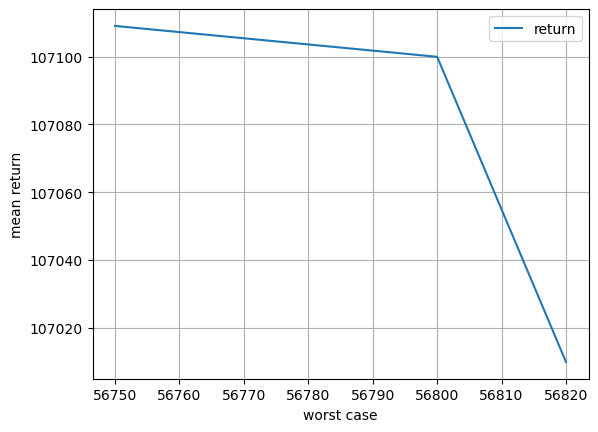

In [369]:
df = pd.DataFrame()

for wc in np.linspace(56750, 56820, 50):
    
    m = farmer(crops, yields)
    
    @m.Constraint(m.SCENARIOS)
    def min_profit(m, s):
        return m.scenario_profit[s] >= wc

    # maximize mean profit
    @m.Objective(sense=pyo.maximize)
    def objective(m):
        return pyo.summation(m.scenario_profit) / len(m.SCENARIOS)

    pyo.SolverFactory('cbc').solve(m)
    
    df.loc[wc, "return"] = m.objective()
    df.loc[wc, "wc"] = wc

df.plot(x="wc", y="return", xlabel="worst case", ylabel="mean return", grid=True)

What we see is that the worst case can be raised from 48,820 to 56,800 (a difference of 7,980 euro) at a cost of reducing the expected from from 108,390 to 107,100 (a reduction of 1,290 euro). This improvement in worst-case performance may be worth the reduction in mean profit.

In [370]:
wc = 56800

m = farmer(crops, yields)
    
@m.Constraint(m.SCENARIOS)
def min_profit(m, s):
    return m.scenario_profit[s] >= wc

# maximize mean profit
@m.Objective(sense=pyo.maximize)
def objective(m):
    return pyo.summation(m.scenario_profit) / len(m.SCENARIOS)

pyo.SolverFactory('cbc').solve(m)

farm_report(m)

Objective = 107100.00

Scenario: good
Scenario profit = 147000.0


,plant [acres],grow [tons],buy [tons],feed [tons],quota [tons],sell [tons],excess [tons],revenue [euro],expense [euro],profit [euro]
wheat,100.0,300.0,0.0,200.0,20000.0,100.0,0.0,17000.0,15000.0,2000.0
corn,100.0,360.0,0.0,240.0,20000.0,120.0,0.0,18000.0,23000.0,-5000.0
beets,300.0,7200.0,0.0,0.0,6000.0,6000.0,1200.0,228000.0,78000.0,150000.0



Scenario: average
Scenario profit = 117500.0


,plant [acres],grow [tons],buy [tons],feed [tons],quota [tons],sell [tons],excess [tons],revenue [euro],expense [euro],profit [euro]
wheat,100.0,250.0,0.0,200.0,20000.0,50.0,0.0,8500.0,15000.0,-6500.0
corn,100.0,300.0,0.0,240.0,20000.0,60.0,0.0,9000.0,23000.0,-14000.0
beets,300.0,6000.0,0.0,0.0,6000.0,6000.0,0.0,216000.0,78000.0,138000.0



Scenario: poor
Scenario profit = 56800.0


,plant [acres],grow [tons],buy [tons],feed [tons],quota [tons],sell [tons],excess [tons],revenue [euro],expense [euro],profit [euro]
wheat,100.0,200.0,0.0,200.0,20000.0,0.0,0.0,0.0,15000.0,-15000.0
corn,100.0,240.0,0.0,240.0,20000.0,0.0,0.0,0.0,23000.0,-23000.0
beets,300.0,4800.0,0.0,0.0,6000.0,4800.0,0.0,172800.0,78000.0,94800.0
